* **Problem statement :** News summarize like inshorts delivers news in less than 60 words.



In [1]:
!pip install rouge-score
import nltk
nltk.download('all')

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=8181a154f3d483a49e5b757e30e5d35037bd54a4633a2d4146a6686fc6a597d3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# setting up some configuration parameters

config = {

    'min_text_len':40,
    'max_text_len':60,
    'max_summary_len':30,
    'letent_dim':300,
    'embedding_dim':200,
    'batch_size': 1024,
    'epochs':20,
    'optimizer':'Adam',
    'loss':'sparse_categorical_crossentropy',
    'metrics':['accuracy']

}

In [4]:
from rouge_score import rouge_scorer

summary = pd.read_csv('https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv', encoding='iso-8859-1')

# Rename columns
raw = raw.rename(columns={'headlines': 'summary'})
summary = summary.rename(columns={'headlines': 'summary'})

df = pd.concat([raw, summary]).reset_index(drop=True)
df = df.drop(columns=['author', 'date', 'read_more', 'ctext'])
print(df.shape)
df.head(3)

(102915, 2)


,summary,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...


In [5]:
raw.shape, summary.shape

((98401, 2), (4514, 6))

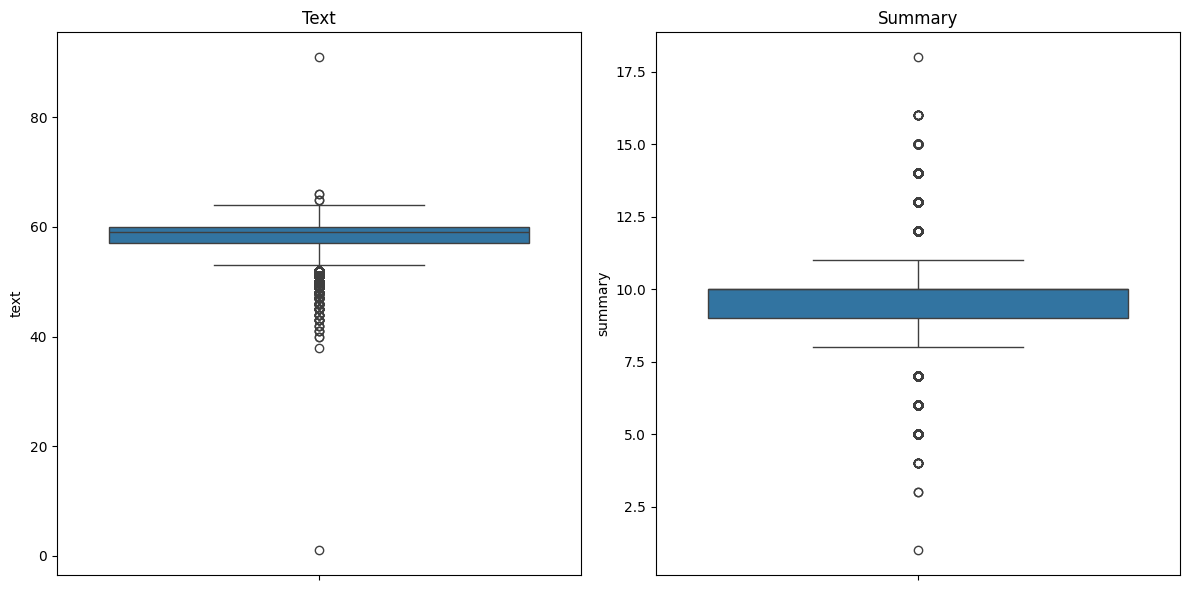

In [6]:
# Distribution of words before filtering


plt.figure(figsize=[12,6])

# First subplot: Distribution of word counts in the 'text' column
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.boxplot(raw.text.str.split().str.len())
plt.title('Text')

# Second subplot: Distribution of word counts in the 'summary' column
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.boxplot(raw.summary.str.split().str.len())
plt.title('Summary')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [7]:

# filter text in range of min and max

print(f'Before filtering {raw.shape}')

pre = df.loc[

    (df.text.str.split(" ").str.len() > config['min_text_len']) &
    (df.text.str.split(" ").str.len() < config['max_text_len'])

    ].reset_index(drop=True)

print(f'After filterig {pre.shape}')

Before filtering (98401, 2)
After filterig (54572, 2)


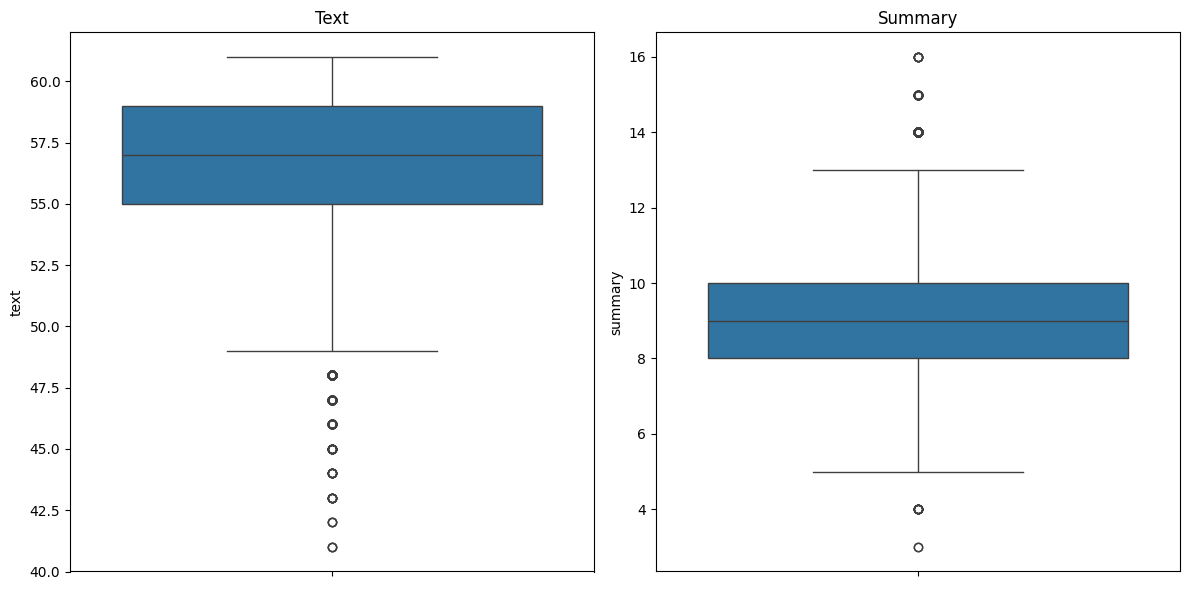

In [8]:
# Distribution of words after filtering

plt.figure(figsize=[12,6])

# First subplot: Distribution of word counts in the 'text' column
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
sns.boxplot(pre.text.str.split().str.len())
plt.title('Text')

# Second subplot: Distribution of word counts in the 'summary' column
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
sns.boxplot(pre.summary.str.split().str.len())
plt.title('Summary')

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [9]:
# looking at the sample

index = 1

print(f'Text : {pre.text[index]}')
print( )
print(f'Summary : {pre.summary[index]}')
print( )
print(f'Length of text : {len(pre.text[index].split())}')
print(f'Length of summary : {len(pre.summary[index].split())}')

Text : India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-digit scores, while their number ten batsman Yuzvendra Chahal top-scored with 18*(37). India's previous lowest ODI total in New Zealand was 108.

Summary : India get all out for 92, their lowest ODI total in New Zealand

Length of text : 56
Length of summary : 13


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, InputLayer, RNN, SimpleRNN, Bidirectional, TimeDistributed
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

import string
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

from sklearn.model_selection import train_test_split

In [12]:
# text preprocessing

import re

# Remove non-alphabetic characters (Data Cleaning)
def text_preprocessing(sentence):
    sentence = re.sub(r"\t", " ", str(sentence)).lower()
    sentence = re.sub(r"\n", " ", str(sentence)).lower()

    # Remove - if it occurs more than one time consecutively
    sentence = re.sub(r"-+", " ", str(sentence)).lower()

    # Remove . if it occurs more than one time consecutively
    sentence = re.sub(r"\.+", " ", str(sentence)).lower()

    # Remove the characters = <>|&©®_~;?!*
    sentence = re.sub(r"[<>©®|&©®~;?!*]", " ", str(sentence)).lower()

    # Remove \x9 in text
    sentence = re.sub(r"\\x9\d", " ", str(sentence)).lower()

    # Replace CM# and CHG# to CM_NUM
    sentence = re.sub(r"([Cc][Mm]\d+)|([Cc][Hh][Gg]\d+)", "CM_NUM", str(sentence)).lower()

    # Remove punctuations at the end of a word
    sentence = re.sub(r"\s+", " ", str(sentence)).lower()

    # Remove multiple spaces
    sentence = re.sub(r"\s+", " ", str(sentence)).lower()

    return sentence


In [13]:
# Get clean text and add START and END point

pre['cleaned_text'] = pre.text.apply(text_preprocessing)
pre['cleaned_summary'] = pre.summary.apply(text_preprocessing).apply(lambda x: 'sostok_START_' + x + '_END_eostok')
pre = pre.drop(columns=['text', 'summary'])
pre.head(3)

,cleaned_text,cleaned_summary
0,pakistani singer rahat fateh ali khan has deni...,sostok_START_rahat fateh ali khan denies getti...
1,india recorded their lowest odi total in new z...,"sostok_START_india get all out for 92, their l..."
2,andhra pradesh cm n chandrababu naidu has said...,sostok_START_called pm modi 'sir' 10 times to ...


In [14]:
print(pre.shape)

post_pre = pre[

               (pre.cleaned_text.str.split( ).str.len() > config['min_text_len']) &
               (pre.cleaned_text.str.split( ).str.len() < config['max_text_len'])

          ].copy()
print(post_pre.shape)

post_pre = post_pre.reset_index(drop=True)
post_pre = post_pre.rename(columns={'cleaned_text': 'text', 'cleaned_summary': 'summary'})
post_pre.head(3)

(54572, 2)
(37504, 2)


,text,summary
0,pakistani singer rahat fateh ali khan has deni...,sostok_START_rahat fateh ali khan denies getti...
1,filmmaker karan johar and actress tabu turned ...,"sostok_START_karan johar, tabu turn showstoppe..."
2,claiming there is a dearth of ideas among oppo...,sostok_START_i think the opposition even dream...


In [15]:
# train and validation data

x_train, x_test, y_train, y_test = train_test_split(np.array(post_pre['text']), np.array(post_pre['summary']), test_size=0.1, random_state=0, shuffle=True)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((33753,), (3751,), (33753,), (3751,))

In [16]:
def get_rare_words(text_col):
    token = Tokenizer()
    token.fit_on_texts(list(text_col))

    threshold = 5

    count = 0
    total_count = 0

    for key, value in token.word_counts.items():
        total_count += 1
        if value < threshold:
            count += 1

    rare_word_percentage = (count / total_count) * 100

    print('% of rare words in vocabulary:', round(rare_word_percentage, 2))

    return count, total_count


Tokenize for Train data

In [17]:
x_train_count, x_train_total_count = get_rare_words(x_train)

% of rare words in vocabulary: 68.43


In [22]:
#prepare tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words=x_train_total_count - x_train_count)
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequence into integer sequence
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

#pad zeros upto maximum length
x_tr = pad_sequences(x_train_seq, maxlen=config['max_text_len'], padding='post')
x_val = pad_sequences(x_test_seq, maxlen=config['max_text_len'], padding='post')

#size of vocabulary (+1 for adding tokens)
x_voc = x_tokenizer.num_words + 1

print('Size of vocablory in x = {}'.format(x_voc))

Size of vocablory in x = 19222


Tokenize for test data

In [28]:
y_train_count, y_train_total_count = get_rare_words(y_train)

% of rare words in vocabulary: 71.8


In [29]:
from tkinter.constants import Y
y_tokenizer = Tokenizer(num_words = y_train_total_count - y_train_count)
y_tokenizer.fit_on_texts(list(y_train))

y_train_seq = y_tokenizer.texts_to_sequences(y_train)
y_test_seq  = y_tokenizer.texts_to_sequences(y_test)

y_tr = pad_sequences(y_train_seq, maxlen=config['max_summary_len'], padding='post')
y_val = pad_sequences(y_test_seq, maxlen=config['max_summary_len'], padding='post')

y_voc = y_tokenizer.num_words + 1

print('Size of Vocablory in y = {}'.format(y_voc))

Size of Vocablory in y = 7791


Initialize the Encoder and Decoder architecture

In [31]:
# Encoder Input
encoder_input = Input(shape=(config['max_text_len'],))

# Embedding Layer
encoder_embedding = Embedding(x_voc, config['embedding_dim'], trainable=True)(encoder_input)

# Encoder LSTM 1
encoder_lstm1 = LSTM(config['letent_dim'], return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(encoder_embedding)

# Encoder LSTM 2
encoder_lstm2 = LSTM(config['letent_dim'], return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(config['letent_dim'], return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
(encoder_output3, state_h3, state_c3) = encoder_lstm3(encoder_output2)

# Decoder Input
decoder_input = Input(shape=(None,))

# Embedding
decoder_embedding = Embedding(y_voc, config['embedding_dim'], trainable=True)(decoder_input)

# Decoder LSTM
decoder_lstm = LSTM(config['letent_dim'], return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
(decoder_output, state_h, state_c) = decoder_lstm(decoder_embedding, initial_state=[state_h3, state_c3])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_output = decoder_dense(decoder_output)

# Define the Model
model = Model([encoder_input, decoder_input], decoder_output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 60)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 60, 200)        │      3,844,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 60, 300),      │        601,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 60, 300),      │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │      1,558,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 60, 300),      │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        601,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 7791)     │      2,345,091 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 10,392,491 (39.64 MB)

 Trainable params: 10,392,491 (39.64 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(optimizer=config['optimizer'], loss=config['loss'], metrics=config['metrics'])

model_name = "./model.weights.h5"

save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name, save_weights_only=True, save_best_only=True, verbose=1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [63]:
history = model.fit(

                   [x_tr, y_tr[:, :-1]],
                   y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
                   epochs = 2,
                   callbacks = [es, save_model],
                   batch_size = config['batch_size'],
                   validation_data = ([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:])

          )

Epoch 1/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.5480 - loss: 6.2526 
Epoch 1: val_loss improved from inf to 2.58905, saving model to ./model.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1447s 43s/step - accuracy: 0.5498 - loss: 6.1959 - val_accuracy: 0.6405 - val_loss: 2.5891
Epoch 2/2
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 41s/step - accuracy: 0.6436 - loss: 2.5690 
Epoch 2: val_loss improved from 2.58905 to 2.34846, saving model to ./model.weights.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1451s 43s/step - accuracy: 0.6440 - loss: 2.5671 - val_accuracy: 0.7015 - val_loss: 2.3485


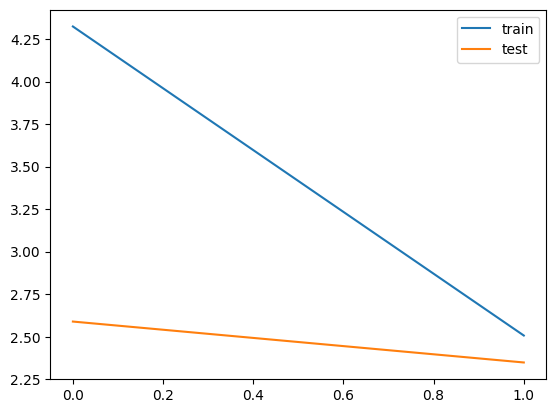

In [66]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

By Implementing some Logic we can summarize the text by these Model.